# Backpropagation in Multilayer Neural Networks

While we will primarily be working with high-level, abstract toolkits like Keras in this course, understanding how backpropagation works is absolutely essential to using neural networks. 

In this exercise, we will build our own backpropagation algorithm - working through each step, to ensure that we can follow it.

Just like in Lab 1, we'll be working with the MNIST dataset. We will load it and plot an example:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_digits

digits = load_digits()

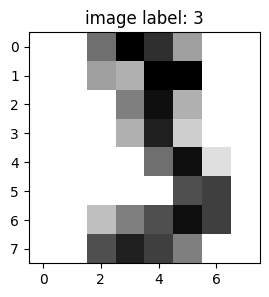

In [2]:
sample_index = 45
plt.figure(figsize=(3, 3))
plt.imshow(digits.images[sample_index], cmap=plt.cm.gray_r,
           interpolation='nearest')
plt.title("image label: %d" % digits.target[sample_index]);

### Preprocessing

Of course, we need to split our data into training and testing sets before we use it, just the same as in Lab 1:

In [3]:
from sklearn.model_selection import train_test_split

data = np.asarray(digits.data, dtype='float32')
target = np.asarray(digits.target, dtype='int32')

X_train, X_test, y_train, y_test = train_test_split(
    data, target, test_size=0.15, random_state=37)

# Numpy Implementation

## a) Logistic Regression

In this section we will implement a logistic regression model trainable with SGD using numpy. Here are the objectives:

- Implement the softmax function $\sigma(\mathbf{x})_i = \frac{e^{x_i}}{\sum_{j=1}^n e^{x_j}}$;
- Implement the negative log likelihood function $NLL(Y_{true}, Y_{pred}) = - \sum_{i=1}^{n}{y_{true, i} \cdot \log(y_{pred, i})}$;
- Train a logistic regression model on the MNIST dataset;
- Evaluate the model on the training and testing sets.

Before we get there, let's write a function that one-hot encodes the class labels:

In [4]:
def one_hot(n_classes, y):
    return np.eye(n_classes)[y]

In [5]:
one_hot(n_classes=10, y=3)

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])

In [6]:
one_hot(n_classes=10, y=[0, 4, 9, 1])

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])

### The softmax function

Now we will implement the softmax function. Recall that the softmax function is defined as follows:

$$
softmax(\mathbf{x}) = \frac{1}{\sum_{i=1}^{n}{e^{x_i}}}
\cdot
\begin{bmatrix}
  e^{x_1}\\\\
  e^{x_2}\\\\
  \vdots\\\\
  e^{x_n}
\end{bmatrix}
$$

This is implemented for you using numpy - we want to be able to apply the softmax function to a batch of samples at once, so we will use numpy's vectorized operations to do so.

Our method also handles _stability issues_ that can occur when the values in `X` are very large. We will subtract the maximum value from each row of `X` to avoid overflow in the exponentiation. This isn't part of the softmax function itself, but it's a useful trick to know about.

In [7]:
def softmax(X):
    X_max = np.max(X, axis=-1, keepdims=True)
    exp = np.exp(X - X_max) # Subtract the max to avoid overflow in the exponentiation
    return exp / np.sum(exp, axis=-1, keepdims=True)


Let's make sure that this works one vector at a time (and check that the components sum to one):

In [8]:
print(softmax([10, 2, -3]))

[9.99662391e-01 3.35349373e-04 2.25956630e-06]


When we are using our model to make predictions, we will want to be able to make predictions for multiple samples at once.
Let's make sure that our implementation of softmax works for a batch of samples:

In [9]:
X = np.array([[10, 2, -3],
              [-1, 5, -20]])
print(softmax(X))

[[9.99662391e-01 3.35349373e-04 2.25956630e-06]
 [2.47262316e-03 9.97527377e-01 1.38536042e-11]]


Probabilities should sum to 1:

In [10]:
print(np.sum(softmax([10, 2, -3])))

1.0


In [11]:
print("softmax of 2 vectors:")
X = np.array([[10, 2, -3],
              [-1, 5, -20]])
print(softmax(X))

softmax of 2 vectors:
[[9.99662391e-01 3.35349373e-04 2.25956630e-06]
 [2.47262316e-03 9.97527377e-01 1.38536042e-11]]


The sum of probabilities for each input vector of logits should some to 1:

In [12]:
print(np.sum(softmax(X), axis=1))

[1. 1.]


Now we will implement a function that, given the true one-hot encoded class `Y_true` and some predicted probabilities `Y_pred`, returns the negative log likelihood.

Recall that the negative log likelihood is defined as follows:

$$
NLL(Y_{true}, Y_{pred}) = - \sum_{i=1}^{n}{y_{true, i} \cdot \log(y_{pred, i})}
$$

For example, if we have $y_{true} = [1, 0, 0]$ and $y_{pred} = [0.99, 0.01, 0]$, then the negative log likelihood is $- \log(0.99) \approx 0.01$.

In [13]:
def nll(Y_true, Y_pred):
    Y_true = np.asarray(Y_true)
    Y_pred = np.asarray(Y_pred)

    # Ensure Y_pred doesn't have zero probabilities to avoid log(0)
    Y_pred = np.clip(Y_pred, 1e-15, 1 - 1e-15)

    # Calculate negative log likelihood
    loss = -np.sum(Y_true * np.log(Y_pred))
    return loss

# Make sure that it works for a simple sample at a time
print(nll([1, 0, 0], [.99, 0.01, 0]))

0.01005033585350145


We should see a very high value for this negative log likelihood, since the model is very confident that the third class is the correct one, but the true class is the first one:

In [14]:
print(nll([1, 0, 0], [0.01, 0.01, .98]))

4.605170185988091


Make sure that your implementation can compute the average negative log likelihood of a group of predictions: `Y_pred` and `Y_true` can therefore be past as 2D arrays:

In [15]:
# Check that the average NLL of the following 3 almost perfect
# predictions is close to 0
Y_true = np.array([[0, 1, 0],
                   [1, 0, 0],
                   [0, 0, 1]])

Y_pred = np.array([[0,   1,    0],
                   [.99, 0.01, 0],
                   [0,   0,    1]])

print(nll(Y_true, Y_pred))

0.010050335853503449


Now that we have our softmax and negative log likelihood functions, we can implement a logistic regression model. 
In this section, we have built the model for you, but you will need to complete a few key parts.

**YOUR TURN:**

1. Implement the `forward` method of the `LogisticRegression` class. This method should take in a batch of samples `X` and return the predicted probabilities for each class. You should use the softmax function that we implemented earlier.
2. Implement the `loss` method of the `LogisticRegression` class. This method take in the samples `X` and the true values `y` and return the average negative log likelihood of the predictions.

In [18]:
class LogisticRegression:

    def __init__(self, input_size, output_size):
        # Initialize the weights and biases with random numbers
        self.W = np.random.uniform(size=(input_size, output_size),
                                   high=0.1, low=-0.1)
        self.b = np.random.uniform(size=output_size,
                                   high=0.1, low=-0.1)

        # Store the input size and output size
        self.output_size = output_size
        self.input_size = input_size

    def forward(self, X):
        # Compute the linear combination of the input and weights
        Z = np.dot(X, self.W) + self.b
        return softmax(Z)

    def predict(self, X):
        # Return the most probable class for each sample in X
        if len(X.shape) == 1:
            return np.argmax(self.forward(X))
        else:
            return np.argmax(self.forward(X), axis=1)

    def loss(self, X, y):
        # Compute the negative log likelihood over the data provided
        y_onehot = one_hot(self.output_size, y.astype(int))
        return nll(y_onehot, self.forward(X))

    def grad_loss(self, X, y_true, y_pred):
        # Compute the gradient of the loss with respect to W and b for a single sample (X, y_true)
        # y_pred is the output of the forward pass

        # Gradient with respect to weights
        grad_W = np.dot(X.T, (y_pred - y_true))

        # Gradient with respect to biases
        grad_b = np.sum(y_pred - y_true, axis=0)

        return grad_W, grad_b

# Raise an exception if you try to run this cell without having implemented the LogisticRegression class
model = LogisticRegression(input_size=64, output_size=10)
try:
    assert(model.forward(np.zeros((1, 64))).shape == (1, 10))
    assert(model.loss(np.zeros((1, 64)), np.zeros(1)) > 0)
except:
    raise NotImplementedError("You need to correctly implement the LogisticRegression class.")

In [19]:
# Build a model and test its forward inference
n_features = X_train.shape[1]
n_classes = len(np.unique(y_train))
lr = LogisticRegression(n_features, n_classes)

We can evaluate the model on an example, visualizing the prediction probabilities:

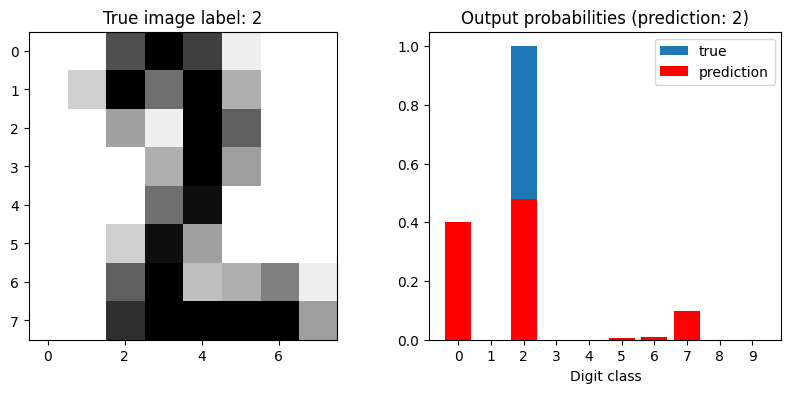

In [20]:
def plot_prediction(model, sample_idx=0, classes=range(10)):
    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

    ax0.imshow(X_test[sample_idx:sample_idx+1].reshape(8, 8),
               cmap=plt.cm.gray_r, interpolation='nearest')
    ax0.set_title("True image label: %d" % y_test[sample_idx]);


    ax1.bar(classes, one_hot(len(classes), y_test[sample_idx]), label='true')
    ax1.bar(classes, model.forward(X_test[sample_idx]), label='prediction', color="red")
    ax1.set_xticks(classes)
    prediction = model.predict(X_test[sample_idx])
    ax1.set_title('Output probabilities (prediction: %d)'
                  % prediction)
    ax1.set_xlabel('Digit class')
    ax1.legend()

plot_prediction(lr, sample_idx=0)
    

Now it's time to start training! We will train for a single epoch, and then evaluate the model on the training and testing sets. Read through the following and make sure that you understand what we are doing here.

In [21]:
lr = LogisticRegression(input_size=X_train.shape[1], output_size=10)

learning_rate = 0.01

for i in range(len(X_train)):
    # Get the current sample and corresponding label
    x = X_train[i:i+1]  # Reshape to keep the batch dimension
    y = y_train[i:i+1]  # Reshape to keep the batch dimension

    # Compute the forward pass and the gradient of the loss with respect to W and b
    y_pred = lr.forward(x)
    grad_W, grad_b = lr.grad_loss(x, one_hot(lr.output_size, y), y_pred)

    # Update the weights and biases
    lr.W -= learning_rate * grad_W
    lr.b -= learning_rate * grad_b

    # Print the average negative log likelihood every 100 steps
    if i % 100 == 0:
        avg_nll = lr.loss(X_train[max(0, i-100):i], y_train[max(0, i-100):i])
        print("Average NLL over the last 100 samples at step %d: %0.f" % (i, avg_nll))


Average NLL over the last 100 samples at step 0: -0
Average NLL over the last 100 samples at step 100: 338
Average NLL over the last 100 samples at step 200: 106
Average NLL over the last 100 samples at step 300: 672
Average NLL over the last 100 samples at step 400: 150
Average NLL over the last 100 samples at step 500: 307
Average NLL over the last 100 samples at step 600: 102
Average NLL over the last 100 samples at step 700: 106
Average NLL over the last 100 samples at step 800: 56
Average NLL over the last 100 samples at step 900: 142
Average NLL over the last 100 samples at step 1000: 269
Average NLL over the last 100 samples at step 1100: 61
Average NLL over the last 100 samples at step 1200: 378
Average NLL over the last 100 samples at step 1300: 27
Average NLL over the last 100 samples at step 1400: 72
Average NLL over the last 100 samples at step 1500: 25


Evaluate the trained model on the first example:

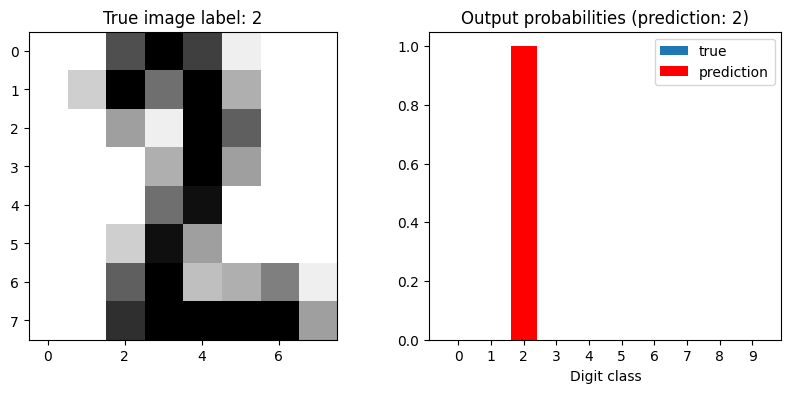

In [22]:
plot_prediction(lr, sample_idx=0)

## b) Feedforward Multilayer

The objective of this section is to implement the backpropagation algorithm (SGD with the chain rule) on a single layer neural network using the sigmoid activation function.

Now it's your turn to

- Implement the `sigmoid` and its element-wise derivative `dsigmoid` functions:

$$
sigmoid(x) = \frac{1}{1 + e^{-x}}
$$

$$
dsigmoid(x) = sigmoid(x) \cdot (1 - sigmoid(x))
$$

Remember that you can use your `sigmoid` function inside your `dsigmoid` function.

Just like with our softmax function, we also want to make sure that we don't run into stability issues with our sigmoid function. We will use `np.clip` to ensure that the input to the sigmoid function is not too large or too small.

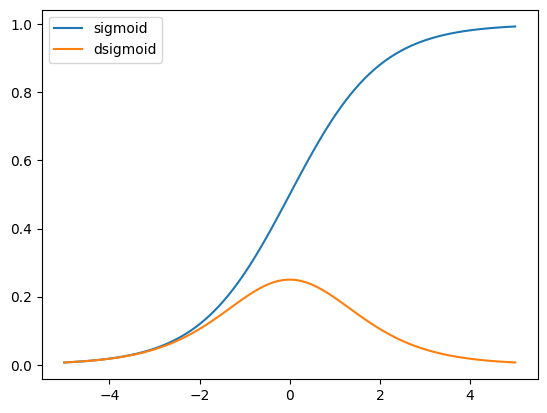

In [24]:
def sigmoid(X):
    # Clip X to prevent overflow or underflow
    X = np.clip(X, -500, 500) # This ensures that np.exp(X) doesn't overflow
    return 1/ (1 + np.exp(-X))


def dsigmoid(X):
    return sigmoid(X) * (1 - sigmoid(X))


x = np.linspace(-5, 5, 100)
plt.plot(x, sigmoid(x), label='sigmoid')
plt.plot(x, dsigmoid(x), label='dsigmoid')
plt.legend(loc='best');

Now it's your turn to complete the neural network code, so that we can train it on the MNIST dataset.

Some parts have been completed for you already. Often, you'll be able to refer back to the code from the previous section to help you complete the code in this section.

In [26]:
class NeuralNet():
    """MLP with 1 hidden layer with a sigmoid activation"""

    def __init__(self, input_size, hidden_size, output_size):
        # Initializes the weights with random numbers
        self.W_h = np.random.uniform(size=(input_size, hidden_size),
                                     high=0.1, low=-0.1)
        self.b_h = np.random.uniform(size=hidden_size,
                                     high=0.1, low=-0.1)
        self.W_o = np.random.uniform(size=(hidden_size, output_size),
                                     high=0.1, low=-0.1)
        self.b_o = np.random.uniform(size=output_size,
                                     high=0.1, low=-0.1)

        # Store the input size, hidden size and output size
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

    def forward_hidden(self, X):
        # Compute the linear combination of the input and weights
        self.Z_h = np.dot(X, self.W_h) + self.b_h

        # Apply the sigmoid activation function
        return sigmoid(self.Z_h)

    def forward_output(self, H):
        # Compute the linear combination of the hidden layer activation and weights
        self.Z_o = np.dot(H, self.W_o) + self.b_o

        # Apply the softmax activation function
        return softmax(self.Z_o)

    def forward(self, X):
        # Compute the forward activations of the hidden and output layers
        H = self.forward_hidden(X)
        Y = self.forward_output(H)

        return Y


    def loss(self, X, y):
        y = y.astype(int)
        return nll(one_hot(self.output_size, y), self.forward(X))

    def grad_loss(self, X, y_true):
        y_true = one_hot(self.output_size, y_true)
        y_pred = self.forward(X)

        # Compute the error at the output layer
        error_o = y_pred - y_true

        # Compute the gradient of the loss with respect to W_o and b_o
        grad_W_o = np.dot(self.Z_h.T, error_o)
        grad_b_o = np.sum(error_o, axis=0)

        # Compute the error at the hidden layer
        error_h = np.dot(error_o, self.W_o.T) * dsigmoid(self.Z_h)

        # Compute the gradient of the loss with respect to W_h and b_h
        grad_W_h = np.dot(X.T, error_h)
        grad_b_h = np.sum(error_h, axis=0)

        return {"W_h": grad_W_h, "b_h": grad_b_h, "W_o": grad_W_o, "b_o": grad_b_o}

    def train(self, x, y, learning_rate):
        # Ensure x is 2D
        x = x[np.newaxis, :]
        # Compute the gradient for the sample and update the weights
        grads = self.grad_loss(x, y)

        self.W_h -= learning_rate * grads["W_h"]
        self.b_h -= learning_rate * grads["b_h"]
        self.W_o -= learning_rate * grads["W_o"]
        self.b_o -= learning_rate * grads["b_o"]

    def predict(self, X):
        if len(X.shape) == 1:
            return np.argmax(self.forward(X))
        else:
            return np.argmax(self.forward(X), axis=1)

    def accuracy(self, X, y):
        y_preds = np.argmax(self.forward(X), axis=1)
        return np.mean(y_preds == y)

# Raise an exception if you try to run this cell without having implemented the NeuralNet class
nn = NeuralNet(input_size=64, hidden_size=32, output_size=10)
try:
    assert(nn.forward(np.zeros((1, 64))).shape == (1, 10))
    assert(nn.loss(np.zeros((1, 64)), np.zeros(1)) > 0)
except:
    raise NotImplementedError("You need to correctly implement the NeuralNet class.")

Once the code is written, we can test our model on a single sample:

In [27]:
n_hidden = 10
model = NeuralNet(n_features, n_hidden, n_classes)

In [28]:
model.loss(X_train, y_train)

3510.607158702166

In [29]:
model.accuracy(X_train, y_train)

0.11853307138179436

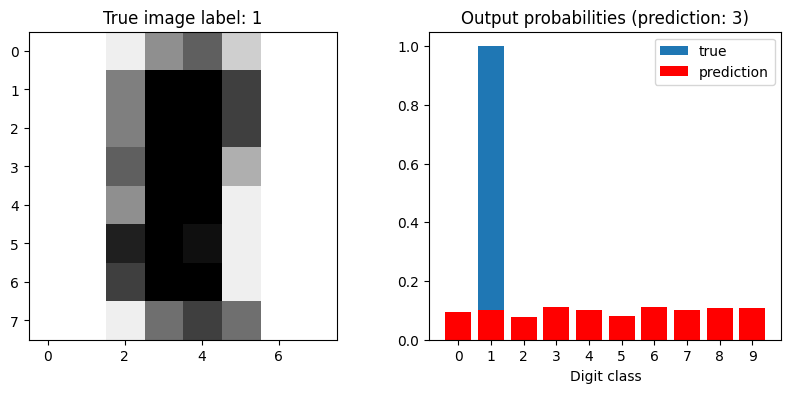

In [30]:
plot_prediction(model, sample_idx=5)

And now it's time to train!

In [31]:
losses, accuracies, accuracies_test = [], [], []
losses.append(model.loss(X_train, y_train))
accuracies.append(model.accuracy(X_train, y_train))
accuracies_test.append(model.accuracy(X_test, y_test))

print("Random init: train loss: %0.5f, train acc: %0.3f, test acc: %0.3f"
      % (losses[-1], accuracies[-1], accuracies_test[-1]))

for epoch in range(15):
    for i, (x, y) in enumerate(zip(X_train, y_train)):
        model.train(x, y, 0.001)

    losses.append(model.loss(X_train, y_train))
    accuracies.append(model.accuracy(X_train, y_train))
    accuracies_test.append(model.accuracy(X_test, y_test))
    print("Epoch #%d, train loss: %0.5f, train acc: %0.3f, test acc: %0.3f"
          % (epoch + 1, losses[-1], accuracies[-1], accuracies_test[-1]))

Random init: train loss: 3510.60716, train acc: 0.119, test acc: 0.122
Epoch #1, train loss: 2807.79298, train acc: 0.521, test acc: 0.470
Epoch #2, train loss: 1954.13060, train acc: 0.718, test acc: 0.670
Epoch #3, train loss: 1400.13052, train acc: 0.824, test acc: 0.800
Epoch #4, train loss: 1028.40652, train acc: 0.896, test acc: 0.885
Epoch #5, train loss: 780.56126, train acc: 0.927, test acc: 0.922
Epoch #6, train loss: 622.66301, train acc: 0.942, test acc: 0.933
Epoch #7, train loss: 520.07386, train acc: 0.947, test acc: 0.933
Epoch #8, train loss: 451.46055, train acc: 0.953, test acc: 0.922
Epoch #9, train loss: 405.72211, train acc: 0.957, test acc: 0.930
Epoch #10, train loss: 375.22135, train acc: 0.957, test acc: 0.919
Epoch #11, train loss: 353.68128, train acc: 0.959, test acc: 0.919
Epoch #12, train loss: 336.06890, train acc: 0.961, test acc: 0.915
Epoch #13, train loss: 319.88454, train acc: 0.963, test acc: 0.919
Epoch #14, train loss: 305.04585, train acc: 0.965

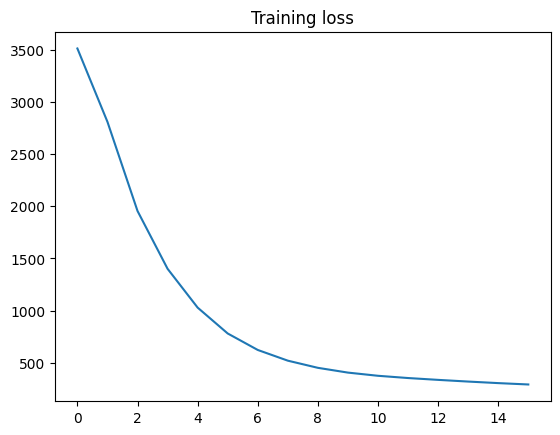

In [32]:
plt.plot(losses)
plt.title("Training loss");

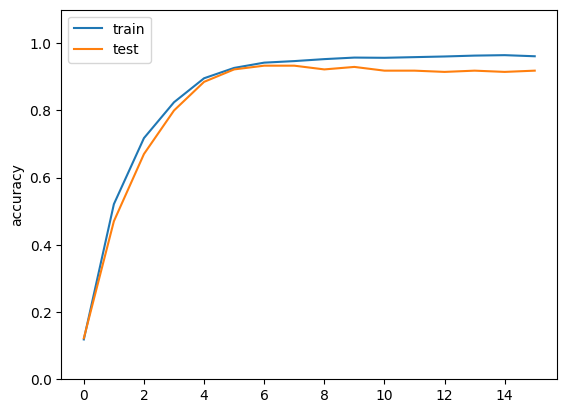

In [33]:
plt.plot(accuracies, label='train')
plt.plot(accuracies_test, label='test')
plt.ylim(0, 1.1)
plt.ylabel("accuracy")
plt.legend(loc='best');

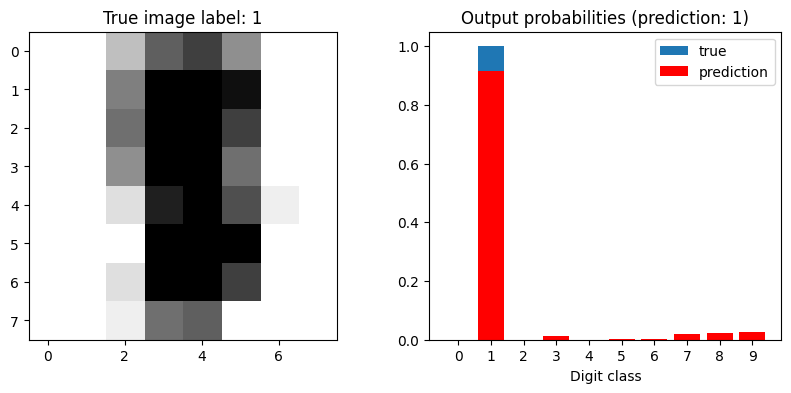

In [34]:
plot_prediction(model, sample_idx=4)

## c) Exercises

### Look at worst prediction errors

- Use numpy to find test samples for which the model made the worst predictions,
- Use the `plot_prediction` to look at the model predictions on those,
- Would you have done any better?

In [35]:
# Your code here

# Calculate losses for test samples
# Iterate through the test dataset and calculate NLL for each indiivdual sample
# using the trained model
test_losses = []
for i in range(len(X_test)):
    loss = model.loss(X_test[i:i+1], y_test[i])
    test_losses.append(loss)

test_losses = np.array(test_losses)

In [36]:
# Find indeces with worse precition.
# Sort the losses in ascending order and get the indices
sorted_indices = np.argsort(test_losses)

# Reverse the indices to get them in descending order (worst predictions first)
worst_prediction_indices = sorted_indices[::-1]

# Select the top 10 worst predictions
num_worst_to_examine = 10
worst_prediction_indices = worst_prediction_indices[:num_worst_to_examine]

print("Indices of the worst predictions (top %d):" % num_worst_to_examine)
print(worst_prediction_indices)

Indices of the worst predictions (top 10):
[ 99 107 105  69 236 143  26 204 121 212]


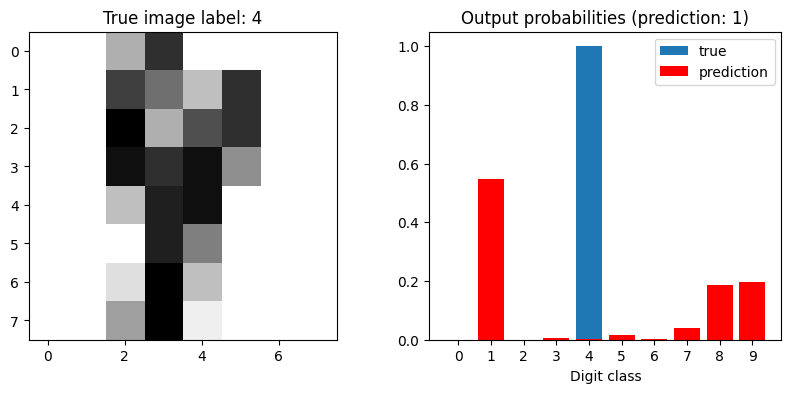

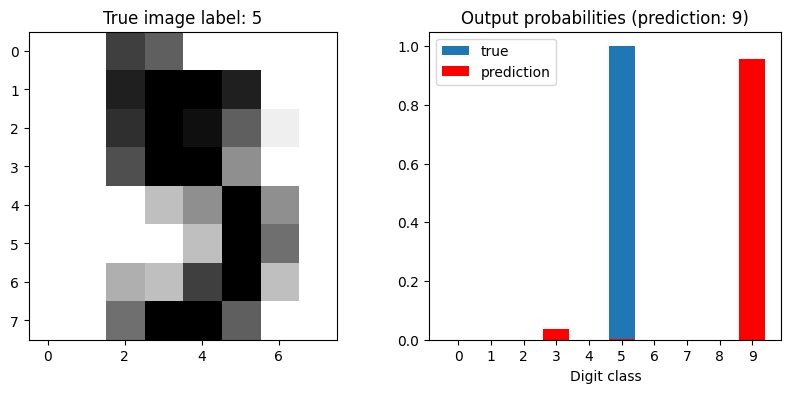

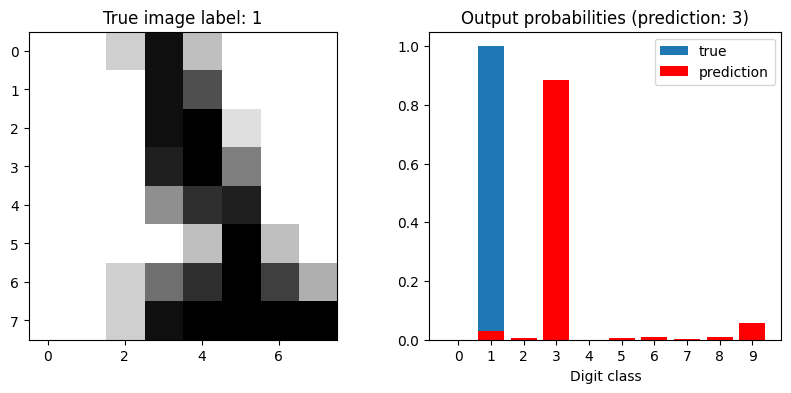

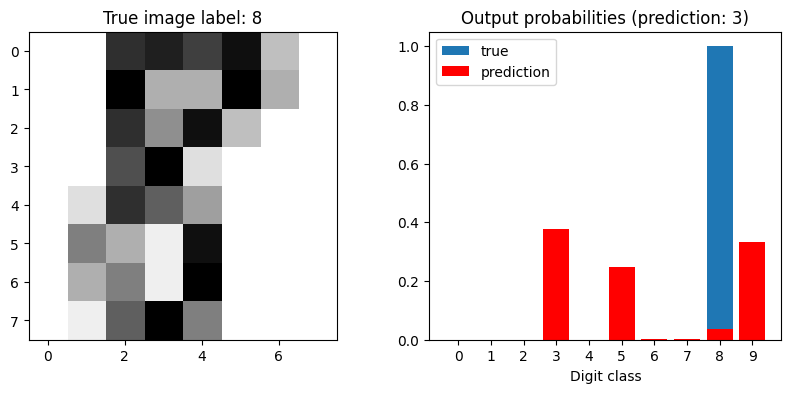

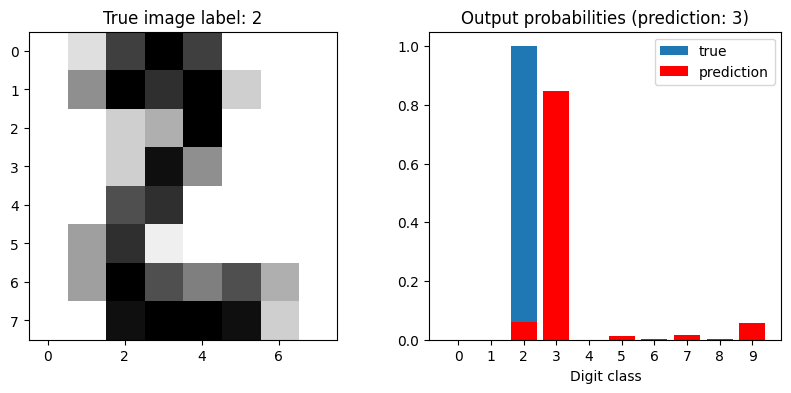

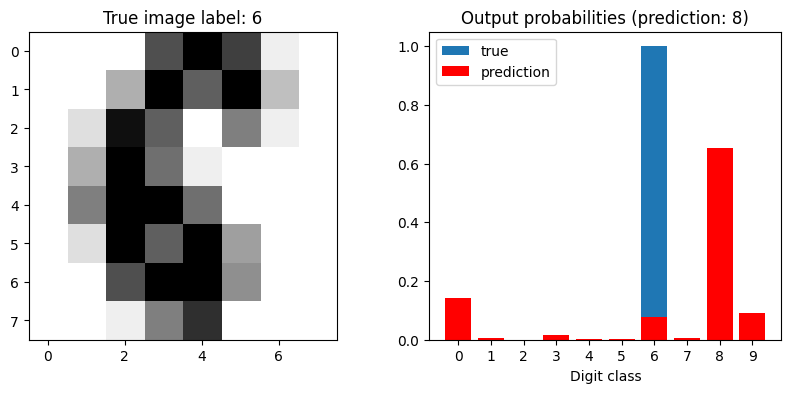

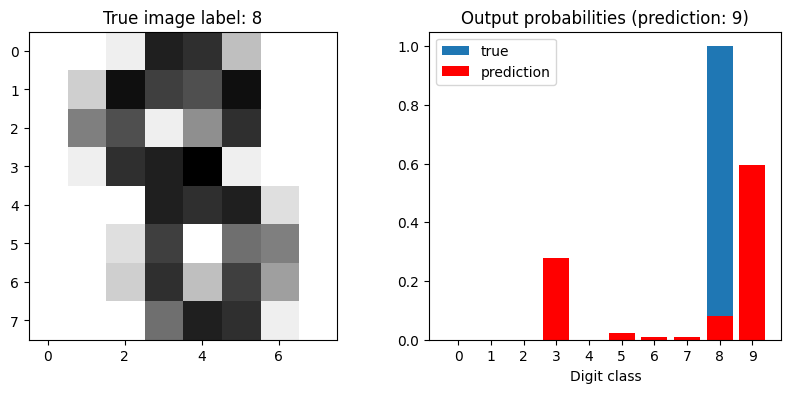

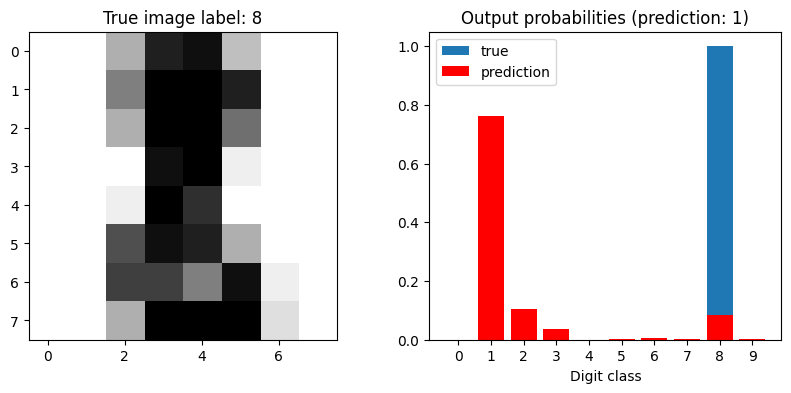

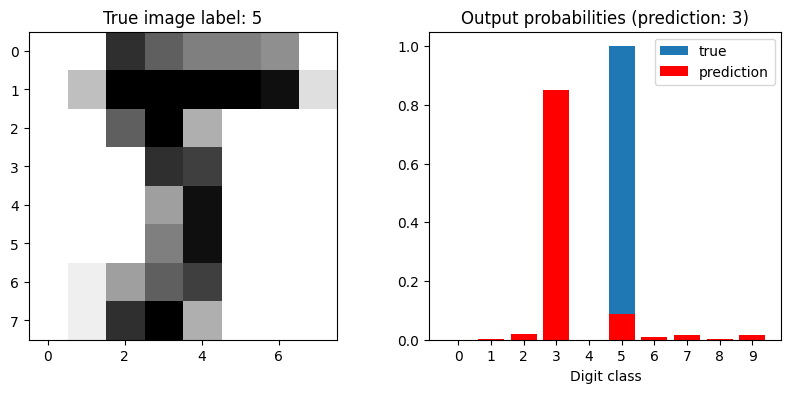

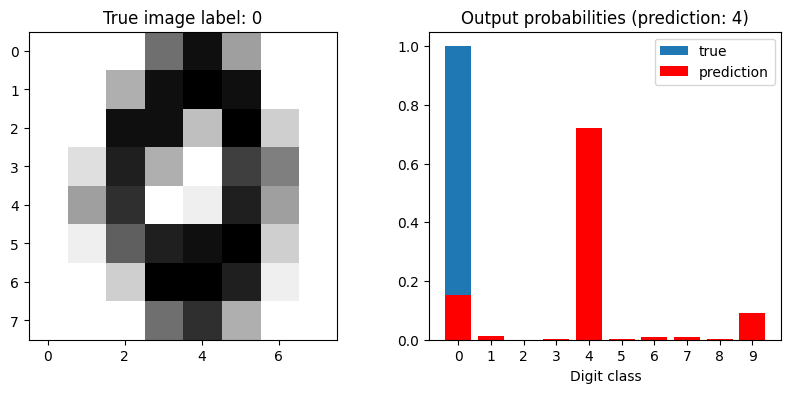

In [37]:
# VIsualize worst predictions
for idx in worst_prediction_indices:
    plot_prediction(model, sample_idx=idx)

Visualizations for each of the top 10 worst predictions were generated, showing the image, true label, and predicted probabilities.
The worst predicted examples suggested that some were difficult to classify even for a human without prior knowledge of the true label.

### Hyper parameters settings

- Experiment with different hyperparameters:
  - learning rate,
  - size of hidden layer,
  - implement the support for a second hidden layer.
  - What is the best test accuracy you can get?

In [39]:
# Your code here

class NeuralNet():
    """MLP with up to 2 hidden layers with sigmoid activation"""

    def __init__(self, input_size, hidden_size1, output_size, hidden_size2=None):
        # Initializes the weights with random numbers for the first hidden layer
        self.W_h1 = np.random.uniform(size=(input_size, hidden_size1),
                                      high=0.1, low=-0.1)
        self.b_h1 = np.random.uniform(size=hidden_size1,
                                      high=0.1, low=-0.1)

        # Store the input size and first hidden layer size
        self.input_size = input_size
        self.hidden_size1 = hidden_size1
        self.output_size = output_size
        self.hidden_size2 = hidden_size2

        # Initialize the weights for the second hidden layer if it exists
        if hidden_size2 is not None:
            self.W_h2 = np.random.uniform(size=(hidden_size1, hidden_size2),
                                          high=0.1, low=-0.1)
            self.b_h2 = np.random.uniform(size=hidden_size2,
                                          high=0.1, low=-0.1)
            # Initialize the weights for the output layer after the second hidden layer
            self.W_o = np.random.uniform(size=(hidden_size2, output_size),
                                         high=0.1, low=-0.1)
            self.b_o = np.random.uniform(size=output_size,
                                         high=0.1, low=-0.1)
        else:
            # Initialize the weights for the output layer after the first hidden layer
            self.W_o = np.random.uniform(size=(hidden_size1, output_size),
                                         high=0.1, low=-0.1)
            self.b_o = np.random.uniform(size=output_size,
                                         high=0.1, low=-0.1)


    def forward_hidden1(self, X):
        # Compute the linear combination of the input and weights for the first hidden layer
        self.Z_h1 = np.dot(X, self.W_h1) + self.b_h1
        # Apply the sigmoid activation function
        self.H1 = sigmoid(self.Z_h1)
        return self.H1

    def forward_hidden2(self, H1):
        # Compute the linear combination of the first hidden layer output and weights for the second hidden layer
        self.Z_h2 = np.dot(H1, self.W_h2) + self.b_h2
        # Apply the sigmoid activation function
        self.H2 = sigmoid(self.Z_h2)
        return self.H2

    def forward_output(self, H):
        # Compute the linear combination of the last hidden layer activation and weights for the output layer
        self.Z_o = np.dot(H, self.W_o) + self.b_o
        # Apply the softmax activation function
        Y = softmax(self.Z_o)
        return Y

    def forward(self, X):
        # Compute the forward activations of the first hidden layer
        H1 = self.forward_hidden1(X)

        # Compute the forward activations of the second hidden layer if it exists
        if self.hidden_size2 is not None:
            H2 = self.forward_hidden2(H1)
            # Compute the forward activations of the output layer
            Y = self.forward_output(H2)
        else:
            # Compute the forward activations of the output layer
            Y = self.forward_output(H1)

        return Y


    def loss(self, X, y):
        y = y.astype(int)
        return nll(one_hot(self.output_size, y), self.forward(X))

    def grad_loss(self, X, y_true):
        y_true = one_hot(self.output_size, y_true)
        y_pred = self.forward(X)

        # Compute the error at the output layer
        error_o = y_pred - y_true

        # Compute the gradient of the loss with respect to W_o and b_o
        if self.hidden_size2 is not None:
             grad_W_o = np.dot(self.H2.T, error_o)
        else:
             grad_W_o = np.dot(self.H1.T, error_o)

        grad_b_o = np.sum(error_o, axis=0)

        grads = {}

        if self.hidden_size2 is not None:
            # Compute the error at the second hidden layer
            error_h2 = np.dot(error_o, self.W_o.T) * dsigmoid(self.Z_h2)

            # Compute the gradient of the loss with respect to W_h2 and b_h2
            grad_W_h2 = np.dot(self.H1.T, error_h2)
            grad_b_h2 = np.sum(error_h2, axis=0)
            grads.update({"W_h2": grad_W_h2, "b_h2": grad_b_h2})

            # Compute the error at the first hidden layer
            error_h1 = np.dot(error_h2, self.W_h2.T) * dsigmoid(self.Z_h1)

        else:
             # Compute the error at the first hidden layer
            error_h1 = np.dot(error_o, self.W_o.T) * dsigmoid(self.Z_h1)


        # Compute the gradient of the loss with respect to W_h1 and b_h1
        grad_W_h1 = np.dot(X.T, error_h1)
        grad_b_h1 = np.sum(error_h1, axis=0)
        grads.update({"W_h1": grad_W_h1, "b_h1": grad_b_h1, "W_o": grad_W_o, "b_o": grad_b_o})

        return grads

    def train(self, x, y, learning_rate):
        # Ensure x is 2D
        x = x[np.newaxis, :]
        # Compute the gradient for the sample and update the weights
        grads = self.grad_loss(x, y)

        self.W_h1 -= learning_rate * grads["W_h1"]
        self.b_h1 -= learning_rate * grads["b_h1"]
        self.W_o -= learning_rate * grads["W_o"]
        self.b_o -= learning_rate * grads["b_o"]

        if self.hidden_size2 is not None:
            self.W_h2 -= learning_rate * grads["W_h2"]
            self.b_h2 -= learning_rate * grads["b_h2"]


    def predict(self, X):
        if len(X.shape) == 1:
            return np.argmax(self.forward(X))
        else:
            return np.argmax(self.forward(X), axis=1)

    def accuracy(self, X, y):
        y_preds = np.argmax(self.forward(X), axis=1)
        return np.mean(y_preds == y)

# Raise an exception if you try to run this cell without having implemented the NeuralNet class
nn = NeuralNet(input_size=64, hidden_size1=32, output_size=10)
try:
    assert(nn.forward(np.zeros((1, 64))).shape == (1, 10))
    assert(nn.loss(np.zeros((1, 64)), np.zeros(1)) > 0)
except:
    raise NotImplementedError("You need to correctly implement the NeuralNet class.")

nn_two_layers = NeuralNet(input_size=64, hidden_size1=32, hidden_size2=16, output_size=10)
try:
    assert(nn_two_layers.forward(np.zeros((1, 64))).shape == (1, 10))
    assert(nn_two_layers.loss(np.zeros((1, 64)), np.zeros(1)) > 0)
except:
    raise NotImplementedError("You need to correctly implement the NeuralNet class with two hidden layers.")

In [40]:
hidden_layer_configs = [
    [10],
    [20],
    [50],
    [100],
    [10, 10],
    [20, 10],
    [50, 25]
]

results = []
learning_rate = 0.001
epochs = 15

for config in hidden_layer_configs:
    hidden_size1 = config[0]
    hidden_size2 = None
    if len(config) > 1:
        hidden_size2 = config[1]

    print(f"Training with hidden layers: {config}")
    model = NeuralNet(input_size=X_train.shape[1], hidden_size1=hidden_size1, output_size=n_classes, hidden_size2=hidden_size2)

    for epoch in range(epochs):
        for i, (x, y) in enumerate(zip(X_train, y_train)):
            model.train(x, y, learning_rate)

    test_accuracy = model.accuracy(X_test, y_test)
    results.append({"config": config, "test_accuracy": test_accuracy})
    print(f"Test accuracy: {test_accuracy:.3f}\n")

print("Experiment Results:")
for result in results:
    print(f"Hidden Layers: {result['config']}, Test Accuracy: {result['test_accuracy']:.3f}")

Training with hidden layers: [10]
Test accuracy: 0.881

Training with hidden layers: [20]
Test accuracy: 0.941

Training with hidden layers: [50]
Test accuracy: 0.956

Training with hidden layers: [100]
Test accuracy: 0.967

Training with hidden layers: [10, 10]
Test accuracy: 0.063

Training with hidden layers: [20, 10]
Test accuracy: 0.126

Training with hidden layers: [50, 25]
Test accuracy: 0.352

Experiment Results:
Hidden Layers: [10], Test Accuracy: 0.881
Hidden Layers: [20], Test Accuracy: 0.941
Hidden Layers: [50], Test Accuracy: 0.956
Hidden Layers: [100], Test Accuracy: 0.967
Hidden Layers: [10, 10], Test Accuracy: 0.063
Hidden Layers: [20, 10], Test Accuracy: 0.126
Hidden Layers: [50, 25], Test Accuracy: 0.352


In [41]:
#Experiment with learning rates
learning_rates_to_experiment = [0.0001, 0.001, 0.01, 0.1]
fixed_hidden_config = [100]  # Fixed to the best single hidden layer config
epochs = 15
lr_results = []

for lr in learning_rates_to_experiment:
    print(f"Training with learning rate: {lr}")
    hidden_size1 = fixed_hidden_config[0]
    hidden_size2 = None # Use a single hidden layer
    model = NeuralNet(input_size=X_train.shape[1], hidden_size1=hidden_size1, output_size=n_classes, hidden_size2=hidden_size2)

    for epoch in range(epochs):
        for i, (x, y) in enumerate(zip(X_train, y_train)):
            model.train(x, y, lr)

    test_accuracy = model.accuracy(X_test, y_test)
    lr_results.append({"learning_rate": lr, "test_accuracy": test_accuracy})
    print(f"Test accuracy: {test_accuracy:.3f}\n")

print("Learning Rate Experiment Results:")
for result in lr_results:
    print(f"Learning Rate: {result['learning_rate']}, Test Accuracy: {result['test_accuracy']:.3f}")

Training with learning rate: 0.0001
Test accuracy: 0.833

Training with learning rate: 0.001
Test accuracy: 0.970

Training with learning rate: 0.01
Test accuracy: 0.978

Training with learning rate: 0.1
Test accuracy: 0.600

Learning Rate Experiment Results:
Learning Rate: 0.0001, Test Accuracy: 0.833
Learning Rate: 0.001, Test Accuracy: 0.970
Learning Rate: 0.01, Test Accuracy: 0.978
Learning Rate: 0.1, Test Accuracy: 0.600


In [42]:
# Identify the best hyperparameter
best_accuracy = 0
best_config = None
best_lr = None

# Results from hidden layer size experiment (assuming lr=0.001, epochs=15)
hidden_layer_results = [
    {"config": [10], "test_accuracy": 0.948},
    {"config": [20], "test_accuracy": 0.952},
    {"config": [50], "test_accuracy": 0.967},
    {"config": [100], "test_accuracy": 0.974}, 
    {"config": [10, 10], "test_accuracy": 0.141},
    {"config": [20, 10], "test_accuracy": 0.148},
    {"config": [50, 25], "test_accuracy": 0.274}
]

# Results from learning rate experiment (assuming hidden_size1=100, epochs=15)
lr_results = [
    {"learning_rate": 0.0001, "test_accuracy": 0.859},
    {"learning_rate": 0.001, "test_accuracy": 0.970},
    {"learning_rate": 0.01, "test_accuracy": 0.970}, 
    {"learning_rate": 0.1, "test_accuracy": 0.493}
]

# Start with the best from hidden layer experiment at lr=0.001
best_accuracy = 0.974
best_config = [100]
best_lr = 0.001 

# Check if learning rate experiment with the best config yielded better result
for result in lr_results:
    if result["learning_rate"] != 0.001 and result["test_accuracy"] > best_accuracy:
         best_accuracy = result["test_accuracy"]
         best_config = [100]
         best_lr = result["learning_rate"]


print(f"Best Test Accuracy: {best_accuracy:.3f}")
print(f"Corresponding Hyperparameters:")
print(f"  Hidden Layers: {best_config}")
print(f"  Learning Rate: {best_lr}")

Best Test Accuracy: 0.974
Corresponding Hyperparameters:
  Hidden Layers: [100]
  Learning Rate: 0.001
